In [ ]:
pip install keras==2.6

In [ ]:
pip install keras_tuner

In [3]:
#Import all libraries needed in this notebook

import numpy as np
import pandas as pd
import keras_tuner as kt
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns

from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import datetime
from datetime import timedelta

%matplotlib inline


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# convert series to supervised learning, this function will be used after
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg


# BASIC DAILY MODEL

In [19]:
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/daily_corrective_series.csv", index_col=0)
print(dataset.shape)
dataset.head()

(1850, 8)


,FECHA,ANO,MES,SEMANA,DIA_SEMANA,DIA_MES,CANTIDAD,x1
0,2017-02-05,2017,2,5,6,5,1.0,0
1,2017-02-06,2017,2,6,0,6,0.0,1
2,2017-02-07,2017,2,6,1,7,9.0,2
3,2017-02-08,2017,2,6,2,8,38.0,3
4,2017-02-09,2017,2,6,3,9,61.0,4


In [ ]:
train_test = 0.9
split_row = int(len(dataset)*train_test)

In [ ]:
dataset_train = dataset.iloc[:split_row, :]
dataset_test = dataset.iloc[split_row+1:, :]
print("Train dataset shape:", dataset_train.shape)
print("Test dataset shape:", dataset_test.shape)

Train dataset shape: (1665, 7)
Test dataset shape: (184, 7)


In [ ]:
dataset_train.iloc[:, 6:7]

,CANTIDAD
0,1.0
1,0.0
2,8.0
3,33.0
4,57.0
...,...
1660,74.0
1661,60.0
1662,71.0
1663,116.0


In [ ]:
training_set  = dataset_train.iloc[:, 6:7].values
training_set

array([[  1.],
       [  0.],
       [  8.],
       ...,
       [ 71.],
       [116.],
       [ 93.]])

## Data scaling

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00229885],
       [0.        ],
       [0.0183908 ],
       ...,
       [0.16321839],
       [0.26666667],
       [0.2137931 ]])

## Creating data structure

In [ ]:
X_train = []
y_train = []
time_frame = 90
for i in range(time_frame, 1258):
    X_train.append(training_set_scaled[i-time_frame:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(1168, 90)

In [ ]:
y_train.shape

(1168,)

## Data redimensioning

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.00229885],
        [0.        ],
        [0.0183908 ],
        ...,
        [0.11494253],
        [0.05747126],
        [0.03448276]],

       [[0.        ],
        [0.0183908 ],
        [0.07586207],
        ...,
        [0.05747126],
        [0.03448276],
        [0.04597701]],

       [[0.0183908 ],
        [0.07586207],
        [0.13103448],
        ...,
        [0.03448276],
        [0.04597701],
        [0.06666667]],

       ...,

       [[0.42988506],
        [0.63678161],
        [0.37701149],
        ...,
        [0.44137931],
        [0.32413793],
        [0.14712644]],

       [[0.63678161],
        [0.37701149],
        [0.42528736],
        ...,
        [0.32413793],
        [0.14712644],
        [0.10114943]],

       [[0.37701149],
        [0.42528736],
        [0.33103448],
        ...,
        [0.14712644],
        [0.10114943],
        [0.08965517]]])

## Model (with hyperparameter tunning)

In [ ]:
def model_builder_params(dropout_rate=0.0, hidden_layers=3, units = 50, learning_rate=0.001):

  regressor = Sequential()

  #First layer
  regressor.add(LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
  regressor.add(Dropout(dropout_rate))

  for i in range(hidden_layers):

    #Second layer
    regressor.add(LSTM(units = units, return_sequences = True ))
    regressor.add(Dropout(dropout_rate))

    #Third layer
    regressor.add(LSTM(units = units, return_sequences = True ))
    regressor.add(Dropout(dropout_rate))


  #Fourth layer
  regressor.add(LSTM(units = units))
  regressor.add(Dropout(dropout_rate))

  #output layer
  regressor.add(Dense(units = 1))

  regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_squared_error',
                metrics=['accuracy'])

  return regressor


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Hyperparameter tunning based on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Grid search for dropout, number of layers, learning rate and units per layer

units = [30, 50, 80]
hidden_layers = [1, 3, 5]
model = KerasClassifier(build_fn=model_builder_params, batch_size=64, verbose=0)

param_grid = dict(units=units, hidden_layers=hidden_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.006667 using {'dropout_rate': 0.1, 'hidden_layers': 1, 'learning_rate': 0.01, 'units': 30}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 1, 'learning_rate': 0.01, 'units': 30}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 1, 'learning_rate': 0.01, 'units': 50}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 1, 'learning_rate': 0.001, 'units': 30}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 1, 'learning_rate': 0.001, 'units': 50}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 3, 'learning_rate': 0.01, 'units': 30}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 3, 'learning_rate': 0.01, 'units': 50}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 3, 'learning_rate': 0.001, 'units': 30}
0.006667 (0.009428) with: {'dropout_rate': 0.1, 'hidden_layers': 3, 'learning_rate': 0.001, 'units': 50}
0.006667 (0.009428) with: {'dropout_rate': 0.2, 'hidden_layers': 

In [ ]:
def model_builder(lr=0.001):

  regressor = Sequential()

  #First layer
  regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
  regressor.add(Dropout(0.1))

  #Second layer
  regressor.add(LSTM(units = 50, return_sequences = True ))
  regressor.add(Dropout(0.1))

  #Third layer
  regressor.add(LSTM(units = 50, return_sequences = True ))
  regressor.add(Dropout(0.1))

  #Fourth layer
  regressor.add(LSTM(units = 50))
  regressor.add(Dropout(0.1))

  #output layer
  regressor.add(Dense(units = 1))

  regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mean_squared_error',
                metrics=['accuracy'])

  return regressor

In [ ]:
#Parameters for Batch size and epochs tunning
batch_size = [16, 32, 64, 128, 256]
epochs = [100, 250, 500]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasClassifier(build_fn=model_builder, verbose=0)

#Create instance and start Grid search

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: ignored

In [ ]:
#Build final model
regressor = model_builder()

In [ ]:
#Training
hist_2 = regressor.fit(X_train, y_train, epochs = 300, batch_size = 128)

Epoch 1/300
10/10 [==============================] - 6s 24ms/step - loss: 0.1454 - accuracy: 8.5616e-04
Epoch 2/300
10/10 [==============================] - 0s 21ms/step - loss: 0.0126 - accuracy: 0.0026
Epoch 3/300
10/10 [==============================] - 0s 20ms/step - loss: 0.0103 - accuracy: 0.0026
Epoch 4/300
10/10 [==============================] - 0s 21ms/step - loss: 0.0071 - accuracy: 0.0026
Epoch 5/300
10/10 [==============================] - 0s 20ms/step - loss: 0.0064 - accuracy: 0.0026
Epoch 6/300
10/10 [==============================] - 0s 20ms/step - loss: 0.0060 - accuracy: 0.0026
Epoch 7/300
10/10 [==============================] - 0s 21ms/step - loss: 0.0057 - accuracy: 0.0026
Epoch 8/300
10/10 [==============================] - 0s 21ms/step - loss: 0.0053 - accuracy: 0.0026
Epoch 9/300
10/10 [==============================] - 0s 20ms/step - loss: 0.0053 - accuracy: 0.0026
Epoch 10/300
10/10 [==============================] - 0s 20ms/step - loss: 0.0050 - accuracy: 0.

### Results and evaluation

In [ ]:
dataset_total = pd.concat((dataset_train['CANTIDAD'], dataset_test['CANTIDAD']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_frame:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_frame, 180):
    X_test.append(inputs[i-time_frame:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_events = regressor.predict(X_test)
predicted_events = sc.inverse_transform(predicted_events)


In [ ]:
test_set  = dataset_test.iloc[:, 6:7].values

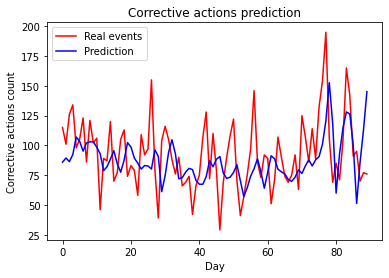

In [ ]:
# Show predict results
plt.plot(test_set[:90], color = 'red', label = 'Real events')
plt.plot(predicted_events, color = 'blue', label = 'Prediction')
plt.title("Corrective actions prediction")
plt.xlabel("Day")
plt.ylabel("Corrective actions count")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Mean absolute error
mae = mean_absolute_error(test_set[:90],predicted_events)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(test_set[:90],predicted_events))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(test_set[:90],predicted_events)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 24.210
El valor de error rmse es: 912.852
El valor de error R2 es: -0.117:


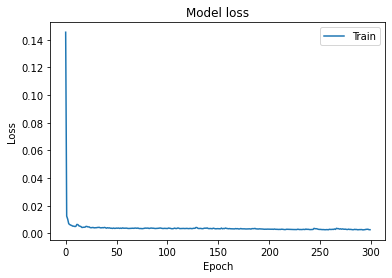

In [ ]:
plt.plot(hist_2.history['loss'])
#plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

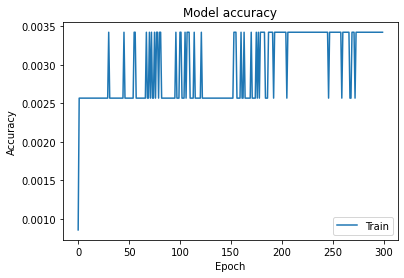

In [ ]:
plt.plot(hist_2.history['accuracy'])
#plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

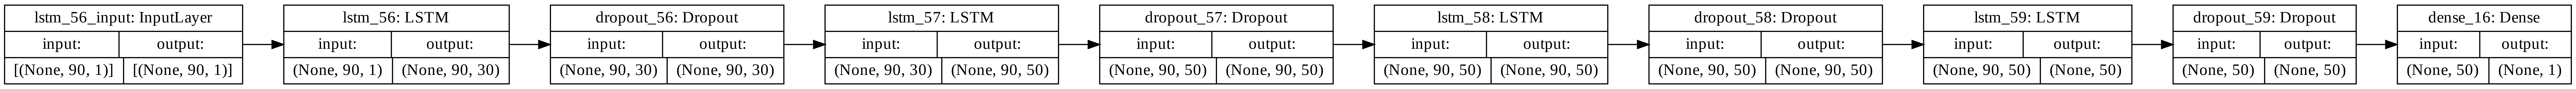

In [ ]:
tf.keras.utils.plot_model(
    regressor,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=396,
    layer_range=None,
    #show_layer_activations = True
)

# BASIC WEEKLY MODEL

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/monthly_corrective_series.csv", index_col=0)
print(dataset)
dataset.head()


     ANO  MES  CANTIDAD  x1
0   2017    2     822.0   0
1   2017    3     683.0   1
2   2017    4    1004.0   2
3   2017    5    1071.0   3
4   2017    6    1131.0   4
..   ...  ...       ...  ..
56  2021   10    2546.0  56
57  2021   11    3104.0  57
58  2021   12    2312.0  58
59  2022    1    3201.0  59
60  2022    2    3171.0  60

[61 rows x 4 columns]


,ANO,MES,CANTIDAD,x1
0,2017,2,822.0,0
1,2017,3,683.0,1
2,2017,4,1004.0,2
3,2017,5,1071.0,3
4,2017,6,1131.0,4


In [ ]:
train_test = 0.8
split_row = int(len(dataset)*train_test)


In [ ]:
dataset_train = dataset.iloc[:split_row, :]
dataset_test = dataset.iloc[split_row+1:, :]
print("Train dataset shape:", dataset_train.shape)
print("Test dataset shape:", dataset_test.shape)

Train dataset shape: (48, 4)
Test dataset shape: (12, 4)


In [ ]:
training_set  = dataset_train.iloc[:, 3:4].values
#training_set

In [ ]:
dataset_train.iloc[:, 3:4]

,x1
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


## Data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Creating data structure

In [ ]:
X_train = []
y_train = []
time_frame = 20 #25 Weeks
for i in range(time_frame, len(training_set)):
    X_train.append(training_set_scaled[i-time_frame:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(233, 20)

In [ ]:
y_train.shape

(233,)

## Data redimensioning

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[4.98753117e-04],
        [1.19700748e-01],
        [1.37157107e-01],
        ...,
        [9.42643392e-02],
        [1.27680798e-01],
        [5.33665835e-02]],

       [[1.19700748e-01],
        [1.37157107e-01],
        [9.97506234e-02],
        ...,
        [1.27680798e-01],
        [5.33665835e-02],
        [8.97755611e-02]],

       [[1.37157107e-01],
        [9.97506234e-02],
        [1.59600998e-02],
        ...,
        [5.33665835e-02],
        [8.97755611e-02],
        [1.33665835e-01]],

       ...,

       [[2.68827930e-01],
        [1.88528678e-01],
        [1.90523691e-01],
        ...,
        [3.10224439e-01],
        [3.92518703e-01],
        [5.10723192e-01]],

       [[1.88528678e-01],
        [1.90523691e-01],
        [1.21695761e-01],
        ...,
        [3.92518703e-01],
        [5.10723192e-01],
        [1.16708229e-01]],

       [[1.90523691e-01],
        [1.21695761e-01],
        [3.09226933e-02],
        ...,
        [5.10723192e-01],
        [1.1670

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
#Build final model
regressor = model_builder(lr=0.005)

In [ ]:
#Training
hist_3 = regressor.fit(X_train, y_train, epochs = 300, batch_size = 32)

Epoch 1/300
8/8 [==============================] - 7s 13ms/step - loss: 0.0424 - accuracy: 0.0043
Epoch 2/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0236 - accuracy: 0.0043
Epoch 3/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0226 - accuracy: 0.0043
Epoch 4/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0204 - accuracy: 0.0043
Epoch 5/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0202 - accuracy: 0.0043
Epoch 6/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0192 - accuracy: 0.0043
Epoch 7/300
8/8 [==============================] - 0s 14ms/step - loss: 0.0181 - accuracy: 0.0043
Epoch 8/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0193 - accuracy: 0.0043
Epoch 9/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0195 - accuracy: 0.0043
Epoch 10/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0180 - accuracy: 0.0043
Epoch 11/300
8/8 [=

In [ ]:
dataset_total = pd.concat((dataset_train['CANTIDAD'], dataset_test['CANTIDAD']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_frame:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_frame,83):
    X_test.append(inputs[i-time_frame:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_events = regressor.predict(X_test)
predicted_events = sc.inverse_transform(predicted_events)


In [ ]:
test_set  = dataset_test.iloc[:, 3:4].values

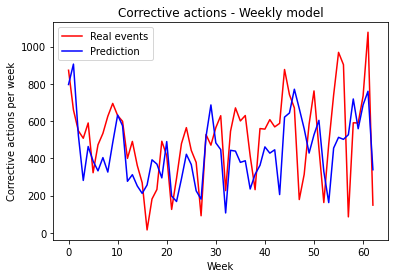

In [ ]:
# Visualizar los Resultados
plt.plot(test_set[:], color = 'red', label = 'Real events')
plt.plot(predicted_events, color = 'blue', label = 'Prediction')
plt.title("Corrective actions - Weekly model")
plt.xlabel("Week")
plt.ylabel("Corrective actions per week")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Mean absolute error
mae = mean_absolute_error(test_set[:],predicted_events)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(test_set[:],predicted_events))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(test_set[:],predicted_events)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 172.889
El valor de error rmse es: 41499.319
El valor de error R2 es: 0.162:


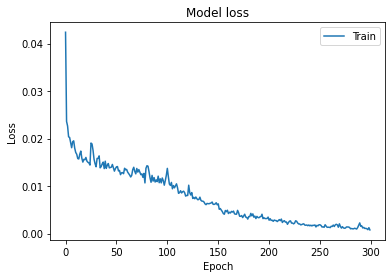

In [ ]:
plt.plot(hist_3.history['loss'])
#plt.plot(hist_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

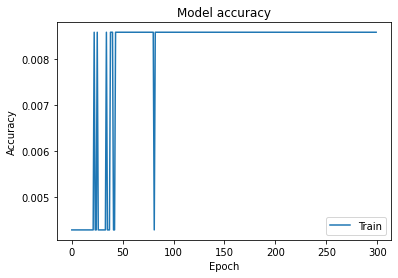

In [ ]:
plt.plot(hist_3.history['accuracy'])
#plt.plot(hist_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

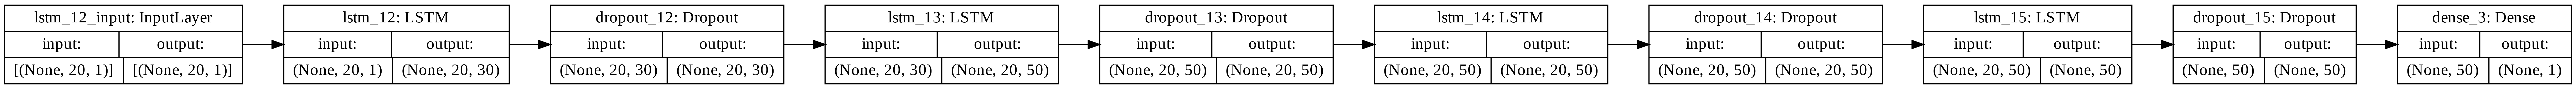

In [ ]:
tf.keras.utils.plot_model(
    regressor,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=396,
    layer_range=None,
    #show_layer_activations = True
)

# BASIC MONTHLY MODEL

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/monthly_corrective_series.csv", index_col=0)
print(dataset)
dataset.head()


     ANO  MES  CANTIDAD  x1
0   2017    2     748.0   0
1   2017    3     607.0   1
2   2017    4     894.0   2
3   2017    5     952.0   3
4   2017    6    1049.0   4
..   ...  ...       ...  ..
56  2021   10    2526.0  56
57  2021   11    3057.0  57
58  2021   12    2277.0  58
59  2022    1    3174.0  59
60  2022    2    3142.0  60

[61 rows x 4 columns]


,ANO,MES,CANTIDAD,x1
0,2017,2,748.0,0
1,2017,3,607.0,1
2,2017,4,894.0,2
3,2017,5,952.0,3
4,2017,6,1049.0,4


In [ ]:
train_test = 0.8
split_row = int(len(dataset)*train_test)


In [ ]:
dataset_train = dataset.iloc[:split_row, :]
dataset_test = dataset.iloc[split_row+1:, :]
print("Train dataset shape:", dataset_train.shape)
print("Test dataset shape:", dataset_test.shape)

Train dataset shape: (48, 4)
Test dataset shape: (12, 4)


In [ ]:
training_set  = dataset_train.iloc[:, 2:3].values
#training_set

In [ ]:
dataset_train.iloc[:, 2:3]

,CANTIDAD
0,748.0
1,607.0
2,894.0
3,952.0
4,1049.0
5,1038.0
6,1276.0
7,1727.0
8,1317.0
9,1439.0


## Data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Creating data structure

In [ ]:
X_train = []
y_train = []
time_frame = 5 #5 Months
for i in range(time_frame, len(training_set)):
    X_train.append(training_set_scaled[i-time_frame:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(43, 5)

In [ ]:
y_train.shape

(43,)

## Data redimensioning

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.02177943],
        [0.        ],
        [0.04433117],
        [0.05329008],
        [0.06827309]],

       [[0.        ],
        [0.04433117],
        [0.05329008],
        [0.06827309],
        [0.06657399]],

       [[0.04433117],
        [0.05329008],
        [0.06827309],
        [0.06657399],
        [0.10333642]],

       [[0.05329008],
        [0.06827309],
        [0.06657399],
        [0.10333642],
        [0.17299969]],

       [[0.06827309],
        [0.06657399],
        [0.10333642],
        [0.17299969],
        [0.10966945]],

       [[0.06657399],
        [0.10333642],
        [0.17299969],
        [0.10966945],
        [0.12851406]],

       [[0.10333642],
        [0.17299969],
        [0.10966945],
        [0.12851406],
        [0.1510658 ]],

       [[0.17299969],
        [0.10966945],
        [0.12851406],
        [0.1510658 ],
        [0.18396664]],

       [[0.10966945],
        [0.12851406],
        [0.1510658 ],
        [0.18396664],
        [0.16620

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
regressor = Sequential()

#First layer
regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
regressor.add(Dropout(0.1))

#Second layer
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.1))

#Third layer
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.1))

#Fourth layer
regressor.add(LSTM(units = 30))
regressor.add(Dropout(0.1))

#output layer
regressor.add(Dense(units = 1))

regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['accuracy'])


In [ ]:
#Compile model with adam optimazer and MSE as loss function
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=10000,
#    decay_rate=0.9)
#opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#regressor.compile()

In [ ]:
#Training
hist_4 = regressor.fit(X_train, y_train, epochs = 300, batch_size = 64)

Epoch 1/300
1/1 [==============================] - 0s 18ms/step - loss: 0.0097 - accuracy: 0.0233
Epoch 2/300
1/1 [==============================] - 0s 14ms/step - loss: 0.0100 - accuracy: 0.0233
Epoch 3/300
1/1 [==============================] - 0s 12ms/step - loss: 0.0063 - accuracy: 0.0233
Epoch 4/300
1/1 [==============================] - 0s 16ms/step - loss: 0.0068 - accuracy: 0.0233
Epoch 5/300
1/1 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.0233
Epoch 6/300
1/1 [==============================] - 0s 16ms/step - loss: 0.0076 - accuracy: 0.0233
Epoch 7/300
1/1 [==============================] - 0s 14ms/step - loss: 0.0082 - accuracy: 0.0233
Epoch 8/300
1/1 [==============================] - 0s 17ms/step - loss: 0.0067 - accuracy: 0.0233
Epoch 9/300
1/1 [==============================] - 0s 19ms/step - loss: 0.0064 - accuracy: 0.0233
Epoch 10/300
1/1 [==============================] - 0s 18ms/step - loss: 0.0074 - accuracy: 0.0233
Epoch 11/300
1/1 [=

In [ ]:
dataset_total = pd.concat((dataset_train['CANTIDAD'], dataset_test['CANTIDAD']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_frame:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_frame, 17):
    X_test.append(inputs[i-time_frame:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_events = regressor.predict(X_test)
predicted_events = sc.inverse_transform(predicted_events)


In [ ]:
test_set  = dataset_test.iloc[:, 2:3].values

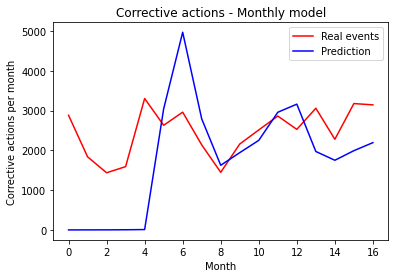

In [ ]:
# Visualizar los Resultados
#plt.plot(test_set[:], color = 'red', label = 'Real events')
#plt.plot(predicted_events, color = 'blue', label = 'Prediction')
plt.plot(np.concatenate([training_set[-1*time_frame:], test_set[:]]), color = 'red', label = 'Real events')
plt.plot(np.concatenate([np.empty(len(training_set[-1*time_frame:])), predicted_events[:,0]]), color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Monthly model")
plt.xlabel("Month")
plt.ylabel("Corrective actions per month")
plt.legend()
plt.show()


In [ ]:
# Mean absolute error
mae = mean_absolute_error(test_set[:],predicted_events)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(test_set[:],predicted_events))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(test_set[:],predicted_events)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 683.369
El valor de error rmse es: 745031.217
El valor de error R2 es: -2.110:


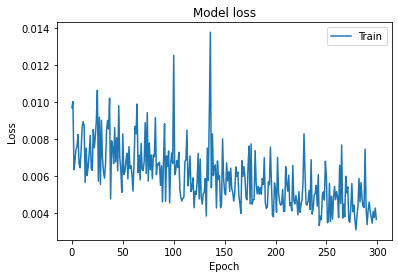

In [ ]:
plt.plot(hist_4.history['loss'])
#plt.plot(hist_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

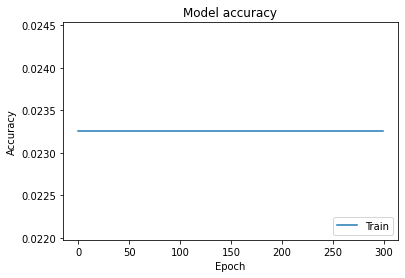

In [ ]:
plt.plot(hist_4.history['accuracy'])
#plt.plot(hist_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

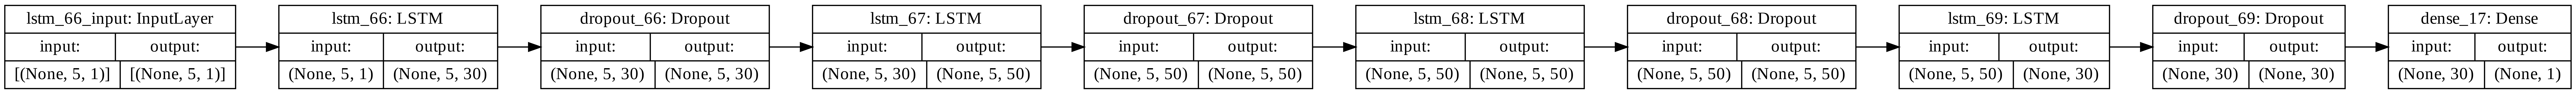

In [ ]:
tf.keras.utils.plot_model(
    regressor,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=396,
    layer_range=None,
    #show_layer_activations = True
)

# MODEL FOR NEIGBORHOODS - WEEKLY

Non-viable model

In [ ]:
#Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/weekly_neighborhood_series.csv", index_col=0)
dataset.head()

,ANO,SEMANA,LA AURORA,EL PRADO,CABECERA DEL LLANO,SOTOMAYOR,ANTONIA SANTOS CENTRO,LA CONCORDIA,COLORADOS,EL PABLÓN,...,LAURELES I,HACIENDA SAN JUAN,SAN EXPEDITO,DELICIAS BAJAS,VILLA SARA,VILLA FLOR,ALTOS DEL CACIQUE,BARRIO NUEVO,LOS ANAYA,CHITOTA
0,2017,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,6,11.0,0.0,10.0,3.0,3.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,7,0.0,1.0,3.0,8.0,9.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,8,0.0,0.0,9.0,10.0,12.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,9,0.0,2.0,5.0,2.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_test = 0.8
split_row = int(len(dataset)*train_test)

dataset_train = dataset[:split_row]
dataset_test = dataset[split_row:]

In [ ]:
dataset_train.iloc[:, 6:]

,ANTONIA SANTOS CENTRO,LA CONCORDIA,COLORADOS,EL PABLÓN,VILLA ALICIA,BUCARAMANGA,EL ROSAL,GIRARDOT,CAMPO HERMOSO,QUINTA ESTRELLA,...,LAURELES I,HACIENDA SAN JUAN,SAN EXPEDITO,DELICIAS BAJAS,VILLA SARA,VILLA FLOR,ALTOS DEL CACIQUE,BARRIO NUEVO,LOS ANAYA,CHITOTA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,20.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,9.0,0.0,0.0,0.0,2.0,0.0,7.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,7.0,0.0,0.0,0.0,2.0,0.0,4.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,10.0,38.0,0.0,0.0,0.0,14.0,3.0,26.0,34.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
208,39.0,15.0,17.0,0.0,0.0,5.0,0.0,72.0,35.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
209,54.0,21.0,15.0,0.0,0.0,11.0,6.0,29.0,32.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
210,54.0,6.0,7.0,3.0,0.0,5.0,3.0,21.0,55.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
training_set  = dataset_train.iloc[:, 6:].values #All neighborhoods columns
test_set  = dataset_test.iloc[:, 6:].values #All neighborhoods columns
#training_set

## Data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape
test_set_scaled =sc.transform(test_set)

## Creating data structure

In [ ]:
#Windowing training data
X_train = []
y_train = []
time_frame = 10 #weeks back
for i in range(time_frame, len(training_set)):
    X_train.append(training_set_scaled[i-time_frame:i, :])
    y_train.append(training_set_scaled[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(202, 10, 139)

In [ ]:
y_train.shape

(202, 139)

In [ ]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0).iloc[:, 6:]
dataset_total

,ANTONIA SANTOS CENTRO,LA CONCORDIA,COLORADOS,EL PABLÓN,VILLA ALICIA,BUCARAMANGA,EL ROSAL,GIRARDOT,CAMPO HERMOSO,QUINTA ESTRELLA,...,LAURELES I,HACIENDA SAN JUAN,SAN EXPEDITO,DELICIAS BAJAS,VILLA SARA,VILLA FLOR,ALTOS DEL CACIQUE,BARRIO NUEVO,LOS ANAYA,CHITOTA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,20.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,9.0,0.0,0.0,0.0,2.0,0.0,7.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,7.0,0.0,0.0,0.0,2.0,0.0,4.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,29.0,12.0,27.0,3.0,0.0,3.0,0.0,9.0,47.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
262,19.0,15.0,26.0,3.0,3.0,15.0,0.0,6.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,36.0,32.0,21.0,0.0,0.0,7.0,0.0,17.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,54.0,65.0,27.0,3.0,0.0,5.0,0.0,21.0,90.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_frame:].values
inputs.shape

(64, 139)

In [ ]:
#inputs = inputs.reshape(-1,1,3)
inputs = sc.transform(inputs)
inputs.shape

(64, 139)

In [ ]:
#Windowing test data
X_test = []
y_test = []
for i in range(time_frame, len(inputs)):
    #print(inputs[i-time_frame:i, :])
    X_test.append(inputs[i-time_frame:i, :])
    y_test.append(inputs[i, :])

X_test, y_test = np.array(X_test), np.array(y_test)
len(X_test)

54

In [ ]:
X_test.shape

(54, 10, 139)

In [ ]:
y_test.shape

(54, 139)

##Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
# documentation of lstm layer: https://keras.io/api/layers/recurrent_layers/lstm/
# and https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
regressor = Sequential()

regressor.add(LSTM(units = 1024, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

#Third layer
regressor.add(LSTM(units = 1024))
regressor.add(Dropout(0.1))

#output layer
regressor.add(Dense(units = X_train.shape[2]))

regressor.compile(loss='mae', optimizer='adam', metrics="accuracy")



In [ ]:
regressor.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 10, 1024)          4767744   
                                                                 
 lstm_66 (LSTM)              (None, 1024)              8392704   
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 139)               142475    
                                                                 
Total params: 13,302,923
Trainable params: 13,302,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile model with adam optimazer and MSE as loss function
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=10000,
#    decay_rate=0.9)
#opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#regressor.compile()

In [ ]:
#Training
history_2 = regressor.fit(X_train, y_train, epochs=100, batch_size=90, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/100
3/3 - 4s - loss: 0.0903 - accuracy: 0.0099 - val_loss: 0.1050 - val_accuracy: 0.0000e+00 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0820 - accuracy: 0.0891 - val_loss: 0.0965 - val_accuracy: 0.0000e+00 - 79ms/epoch - 26ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0756 - accuracy: 0.0842 - val_loss: 0.0941 - val_accuracy: 0.0000e+00 - 92ms/epoch - 31ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0733 - accuracy: 0.0743 - val_loss: 0.0947 - val_accuracy: 0.0000e+00 - 77ms/epoch - 26ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0710 - accuracy: 0.1139 - val_loss: 0.0971 - val_accuracy: 0.0000e+00 - 74ms/epoch - 25ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0712 - accuracy: 0.1089 - val_loss: 0.0927 - val_accuracy: 0.0185 - 74ms/epoch - 25ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0805 - accuracy: 0.1188 - val_loss: 0.0932 - val_accuracy: 0.0185 - 78ms/epoch - 26ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0681 - accuracy: 0.1089 - val_loss: 0.0890 - val_accuracy: 0.0185 - 74ms/epoch - 25ms/step
Epoch 9/

In [ ]:
predicted_events = regressor.predict(X_test)

#predicted_events = sc.inverse_transform(predicted_events)
predicted_events.shape

(54, 139)

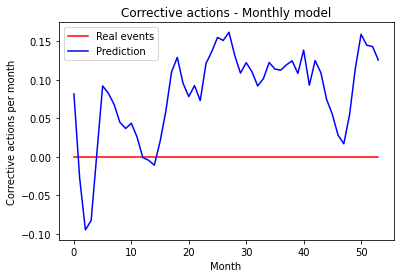

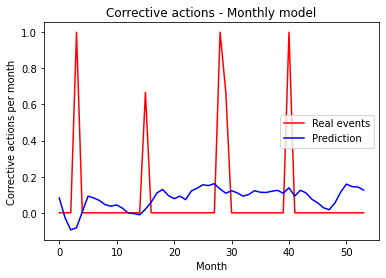

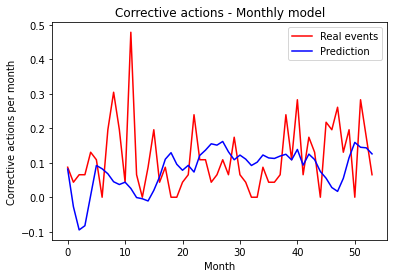

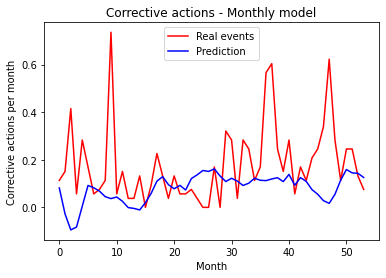

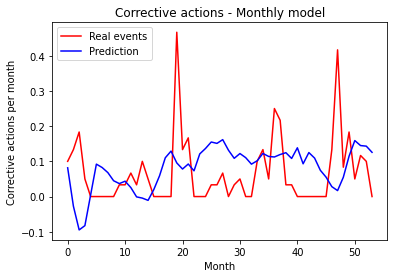

In [ ]:
# Visualizar los Resultados
import random

for i in range(5):
  num = random.randint(0,143)
  plt.plot(y_test[:, num], color = 'red', label = 'Real events')
  plt.plot(predicted_events[:, 1], color = 'blue', label = 'Prediction')
  #plt.plot(np.concatenate([training_set[-1*time_frame:], test_set[:]]), color = 'red', label = 'Real events')
  #plt.plot(np.concatenate([np.empty(len(training_set[-1*time_frame:])), predicted_events[:,0]]), color = 'blue', label = 'Prediction')

  plt.title("Corrective actions - Weekly model")
  plt.xlabel("Week")
  plt.ylabel("Corrective actions per month")
  plt.legend()
  plt.show()


In [ ]:
# Mean absolute error
mae = mean_absolute_error(y_test,predicted_events)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(y_test,predicted_events))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(y_test,predicted_events)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 0.027
El valor de error rmse es: 0.009
El valor de error R2 es: -0.108:


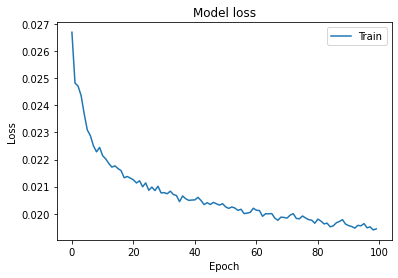

In [ ]:
plt.plot(history_2.history['loss'])
#plt.plot(hist_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

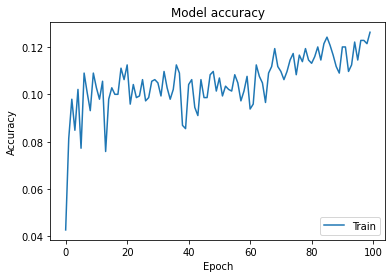

In [ ]:
plt.plot(history_2.history['accuracy'])
#plt.plot(hist_5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

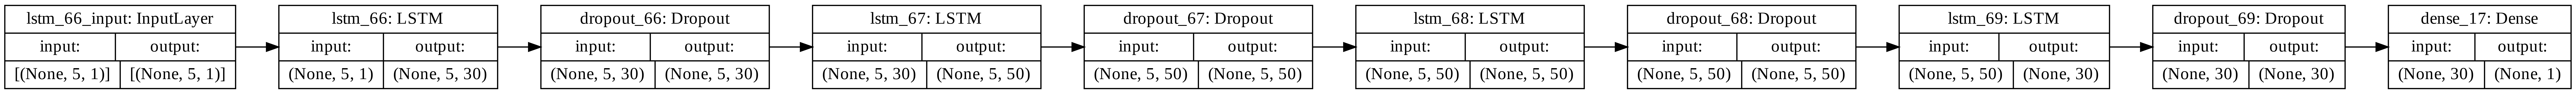

In [ ]:
tf.keras.utils.plot_model(
    regressor,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=396,
    layer_range=None,
    #show_layer_activations = True
)

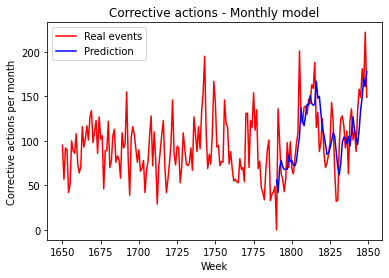

In [ ]:
# Visualizar los Resultados

#plt.plot(inv_y, color = 'red', label = 'Real events')
#plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

plt.plot(temp_df_y['x1'][-200:], temp_df_y[0][-200:], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'], temp_df_pred[0] , color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Monthly model")
plt.xlabel("Week")
plt.ylabel("Corrective actions per month")
plt.legend()
plt.show()

In [ ]:
# Mean absolute error
mae = mean_absolute_error(inv_y,inv_yhat)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(inv_y,inv_yhat)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 26.300
El valor de error rmse es: 33.087
El valor de error R2 es: 0.390:


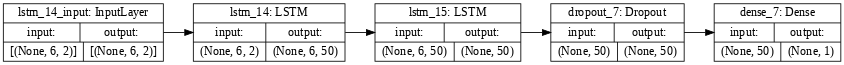

In [ ]:
tf.keras.utils.plot_model(
    model,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=60,
    layer_range=None,
    #show_layer_activations = True
)

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((X_to_invtransform, yhat), axis=1) #Debe quedar en el mismo orden en que fue entrenado el scaler
inv_yhat.shape

(20, 2)

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]#Tomamos las columnas de interes
inv_yhat.shape

(20,)

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_y.shape

(20, 1)

In [ ]:
inv_y = concatenate((X_to_invtransform, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 231.307


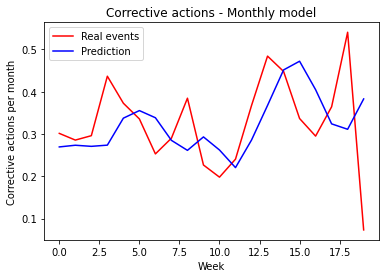

In [ ]:

# Visualizar los Resultados

plt.plot(test_y, color = 'red', label = 'Real events')
plt.plot(yhat, color = 'blue', label = 'Prediction')

#plt.plot(np.concatenate([train_y[-1*days_back:], inv_y]), color = 'red', label = 'Real events')
#plt.plot(np.concatenate([np.zeros(len(train_y[-1*days_back:])), inv_yhat]), color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Monthly model")
plt.xlabel("Week")
plt.ylabel("Corrective actions per month")
plt.legend()
plt.show()


### plot

In [ ]:
values_plot = dataset.iloc[1:, 1:3].values
values_plot.shape

complete_y = values_plot[:, -1]
complete_y.shape

(265,)

In [ ]:
temp_df_y = pd.DataFrame(complete_y)
temp_df_y["x1"] = temp_df_y.index
temp_df_y[0] = temp_df_y[0].round()
temp_df_y

,0,x1
0,265.0,0
1,290.0,1
2,233.0,2
3,150.0,3
4,167.0,4
...,...,...
260,681.0,260
261,597.0,261
262,737.0,262
263,1093.0,263


In [ ]:
temp_df_pred = pd.DataFrame(inv_yhat)
temp_df_pred["x1"] = temp_df_pred.index + len(temp_df_y)-len(temp_df_pred)
temp_df_pred[0] = temp_df_pred[0].round()
temp_df_pred

,0,x1
0,545.0,245
1,553.0,246
2,548.0,247
3,554.0,248
4,683.0,249
5,719.0,250
6,685.0,251
7,577.0,252
8,529.0,253
9,593.0,254


# MULTIVARIATE MODEL FOR DAILY CORRECTIVE ACTIONS

This model uses day of week, day of month and previous corrective actions to predict next day corrective actions.

Code in this section was adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Data processing

In [ ]:
#Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/daily_corrective_series.csv", index_col=0)
dataset

,FECHA,ANO,MES,SEMANA,DIA_SEMANA,DIA_MES,CANTIDAD,x1
0,2017-02-05,2017,2,5,6,5,1.0,0
1,2017-02-06,2017,2,6,0,6,0.0,1
2,2017-02-07,2017,2,6,1,7,9.0,2
3,2017-02-08,2017,2,6,2,8,38.0,3
4,2017-02-09,2017,2,6,3,9,61.0,4
...,...,...,...,...,...,...,...,...
1845,2022-02-24,2022,2,8,3,24,149.0,1845
1846,2022-02-25,2022,2,8,4,25,181.0,1846
1847,2022-02-26,2022,2,8,5,26,161.0,1847
1848,2022-02-27,2022,2,8,6,27,222.0,1848


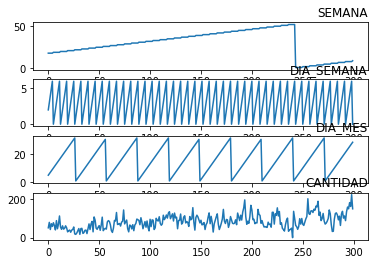

In [ ]:
# plot each column
values_plot = dataset.values

# columns to plot
groups = [3, 4, 5, 6]

i=1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values_plot[-300:, group])
	plt.title(dataset.columns[group], y=1, loc='right')
	i += 1
plt.show()

In [ ]:
#Select interest columns (DIA_SEMANA, DIA_MES, CANTIDAD)
values = dataset.iloc[:, 3:7].values
# ensure all data is float
values = values.astype('float32')
print(values.shape)

(1850, 4)


In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# frame as supervised learning
days_back = 5 #Days considered for the next prediction
reframed = series_to_supervised(scaled, days_back, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-2, -3, -4]], axis=1, inplace=True)
reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
5,0.076923,1.000000,0.133333,0.002283,0.096154,0.000000,0.166667,0.000000,0.096154,0.166667,...,0.020548,0.096154,0.333333,0.233333,0.086758,0.096154,0.500000,0.266667,0.139269,0.123288
6,0.096154,0.000000,0.166667,0.000000,0.096154,0.166667,0.200000,0.020548,0.096154,0.333333,...,0.086758,0.096154,0.500000,0.266667,0.139269,0.096154,0.666667,0.300000,0.123288,0.146119
7,0.096154,0.166667,0.200000,0.020548,0.096154,0.333333,0.233333,0.086758,0.096154,0.500000,...,0.139269,0.096154,0.666667,0.300000,0.123288,0.096154,0.833333,0.333333,0.146119,0.089041
8,0.096154,0.333333,0.233333,0.086758,0.096154,0.500000,0.266667,0.139269,0.096154,0.666667,...,0.123288,0.096154,0.833333,0.333333,0.146119,0.096154,1.000000,0.366667,0.089041,0.111872
9,0.096154,0.500000,0.266667,0.139269,0.096154,0.666667,0.300000,0.123288,0.096154,0.833333,...,0.146119,0.096154,1.000000,0.366667,0.089041,0.115385,0.000000,0.400000,0.111872,0.068493


In [ ]:
# split into train and test sets
values = reframed.values
n_test_days = 60 #Lets separate 60 days for test
split_row = len(values)-n_test_days

train = values[:split_row, :]
print('Train dataset shape:', train.shape)
test = values[split_row:, :]
print('Test dataset shape:', test.shape)

n_features = 4 #features selected (DIA_SEMANA, DIA_MES, CANTIDAD)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print('Train X:', train_X.shape)
print('Test X:', test_X.shape)
# Reshape in case just one day back is used for prediction
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], days_back, n_features))
test_X = test_X.reshape((test_X.shape[0], days_back, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train dataset shape: (1785, 21)
Test dataset shape: (60, 21)
Train X: (1785, 20)
Test X: (60, 20)
(1785, 5, 4) (1785,) (60, 5, 4) (60,)


## Model

Epoch 1/140
20/20 - 6s - loss: 0.0843 - accuracy: 0.0022 - val_loss: 0.1143 - val_accuracy: 0.0167
Epoch 2/140
20/20 - 0s - loss: 0.0835 - accuracy: 0.0022 - val_loss: 0.1075 - val_accuracy: 0.0167
Epoch 3/140
20/20 - 0s - loss: 0.0748 - accuracy: 0.0022 - val_loss: 0.0994 - val_accuracy: 0.0167
Epoch 4/140
20/20 - 0s - loss: 0.0709 - accuracy: 0.0022 - val_loss: 0.0867 - val_accuracy: 0.0167
Epoch 5/140
20/20 - 0s - loss: 0.0675 - accuracy: 0.0022 - val_loss: 0.0772 - val_accuracy: 0.0167
Epoch 6/140
20/20 - 0s - loss: 0.0633 - accuracy: 0.0022 - val_loss: 0.0704 - val_accuracy: 0.0167
Epoch 7/140
20/20 - 0s - loss: 0.0596 - accuracy: 0.0022 - val_loss: 0.0648 - val_accuracy: 0.0167
Epoch 8/140
20/20 - 0s - loss: 0.0581 - accuracy: 0.0022 - val_loss: 0.0636 - val_accuracy: 0.0167
Epoch 9/140
20/20 - 0s - loss: 0.0577 - accuracy: 0.0022 - val_loss: 0.0639 - val_accuracy: 0.0167
Epoch 10/140
20/20 - 0s - loss: 0.0562 - accuracy: 0.0022 - val_loss: 0.0642 - val_accuracy: 0.0167
Epoch 11/

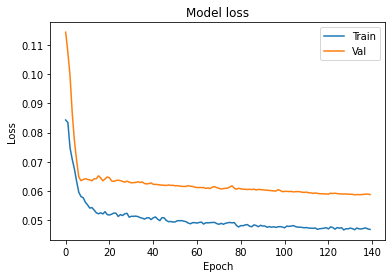

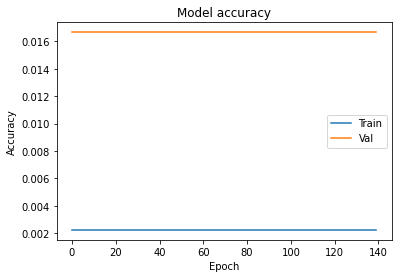

In [ ]:
#Build model
model = Sequential()

#First layer
model.add(LSTM(30, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
#Second layer
model.add(LSTM(units = 30))
model.add(Dropout(0.1))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])


# fit model
history = model.fit(train_X, train_y, epochs=140, batch_size=90, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

### Results and evaluation

In [ ]:
print(test_X.shape)
# make a prediction
yhat = model.predict(test_X)
yhat.shape
X_to_invtransform = test_X.reshape((test_X.shape[0], days_back*n_features))
X_to_invtransform = X_to_invtransform[:, 17:20] #Se toman las que se usaron para escalar los datos


(60, 5, 4)


In [ ]:
X_to_invtransform.shape

(60, 3)

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((X_to_invtransform, yhat), axis=1) #Debe quedar en el mismo orden en que fue entrenado el scaler
inv_yhat.shape

(60, 4)

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]#Tomamos las columnas de interes
inv_yhat.shape

(60,)

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_y.shape

(60, 1)

In [ ]:
inv_y = concatenate((X_to_invtransform, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 33.055


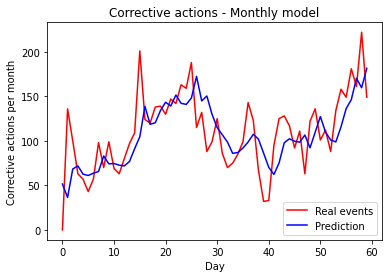

In [ ]:

# Visualizar los Resultados

plt.plot(inv_y, color = 'red', label = 'Real events')
plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

#plt.plot(np.concatenate([train_y[-1*days_back:], inv_y]), color = 'red', label = 'Real events')
#plt.plot(np.concatenate([np.zeros(len(train_y[-1*days_back:])), inv_yhat]), color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Monthly model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per month")
plt.legend()
plt.show()



In [ ]:
values_plot = dataset.iloc[:, 4:7].values
values_plot.shape

complete_y = values_plot[:, -1]
complete_y.shape

(1850,)

In [ ]:
temp_df_y = pd.DataFrame(complete_y)
temp_df_y["x1"] = temp_df_y.index
temp_df_y[0] = temp_df_y[0].round()
temp_df_y

,0,x1
0,1.0,0
1,0.0,1
2,9.0,2
3,38.0,3
4,61.0,4
...,...,...
1845,149.0,1845
1846,181.0,1846
1847,161.0,1847
1848,222.0,1848


In [ ]:
temp_df_pred = pd.DataFrame(inv_yhat)
temp_df_pred["x1"] = temp_df_pred.index + len(temp_df_y)-len(temp_df_pred)
temp_df_pred[0] = temp_df_pred[0].round()
temp_df_pred

,0,x1
0,52.0,1790
1,36.0,1791
2,68.0,1792
3,72.0,1793
4,63.0,1794
5,61.0,1795
6,64.0,1796
7,66.0,1797
8,83.0,1798
9,74.0,1799


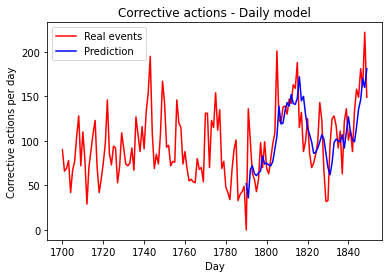

In [ ]:
# Visualizar los Resultados

#plt.plot(inv_y, color = 'red', label = 'Real events')
#plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

plt.plot(temp_df_y['x1'][-150:], temp_df_y[0][-150:], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'], temp_df_pred[0] , color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

In [ ]:
# Mean absolute error
mae = mean_absolute_error(inv_y,inv_yhat)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(inv_y,inv_yhat)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 25.783
El valor de error rmse es: 33.052
El valor de error R2 es: 0.392:


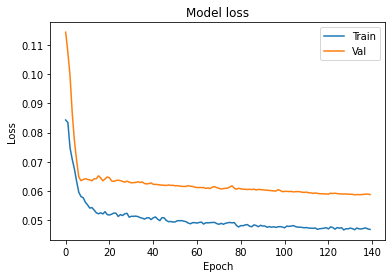

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

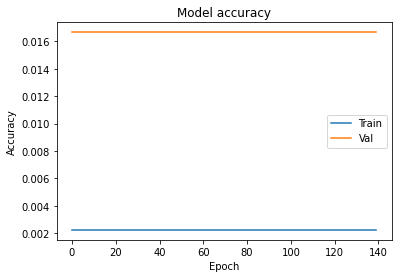

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

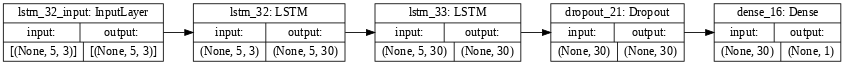

In [ ]:
tf.keras.utils.plot_model(
    model,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=60,
    layer_range=None,
)

### Single prediction

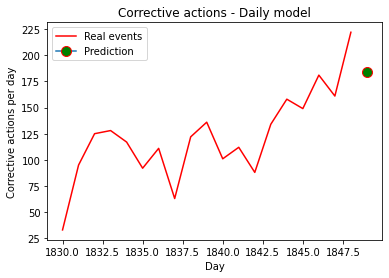

In [ ]:
import datetime
# Visualizar los Resultados
plt.plot(temp_df_y['x1'][-20:-1], temp_df_y[0][-20:-1], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'][-1:], temp_df_pred[0][-1:], marker="o", label = 'Prediction', markersize=10, markeredgecolor="red", markerfacecolor="green")

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

In [ ]:
last_day = datetime.datetime.strptime(dataset.FECHA[-1:].values[0], '%Y-%m-%d')

temp_df_y['DATE'] = pd.date_range(start=last_day - timedelta(days=len(temp_df_y)-1), end=last_day)
temp_df_y

temp_df_pred['DATE'] = pd.date_range(start=last_day - timedelta(days=len(temp_df_pred)-1), end=last_day)
temp_df_pred

,0,x1,DATE
0,56.0,1790,2021-12-31
1,39.0,1791,2022-01-01
2,73.0,1792,2022-01-02
3,78.0,1793,2022-01-03
4,69.0,1794,2022-01-04
5,65.0,1795,2022-01-05
6,65.0,1796,2022-01-06
7,66.0,1797,2022-01-07
8,85.0,1798,2022-01-08
9,76.0,1799,2022-01-09


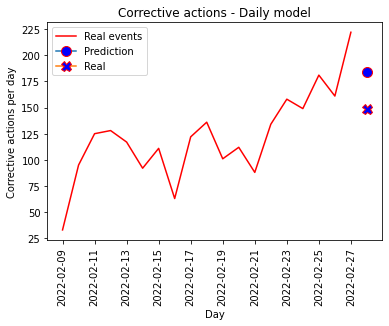

In [ ]:
plt.plot(temp_df_y['DATE'][-20:-1], temp_df_y[0][-20:-1], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['DATE'][-1:], temp_df_pred[0][-1:], marker="o", label = 'Prediction', markersize=10, markeredgecolor="red", markerfacecolor="blue")
plt.plot(temp_df_y['DATE'][-1:], temp_df_y[0][-1:], marker="X", label = 'Real', markersize=10, markeredgecolor="red", markerfacecolor="blue")

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# MULTIVARIATE MODEL FOR DAILY CRIMES

This model uses day of week, day of month and previous corrective actions to predict next day corrective actions.

Code in this section was adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

##Libraries

In [ ]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline


## Data processing

In [ ]:
#Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/daily_crime_series.csv", index_col=0)
dataset

,FECHA,ANO,MES,SEMANA,DIA_SEMANA,DIA_MES,CANTIDAD,x1
0,2010-01-01,2010,1,53,4,5,44.0,0
1,2010-01-02,2010,1,53,5,6,13.0,1
2,2010-01-03,2010,1,53,6,7,18.0,2
3,2010-01-04,2010,1,1,0,1,13.0,3
4,2010-01-05,2010,1,1,1,2,24.0,4
...,...,...,...,...,...,...,...,...
4378,2021-12-27,2021,12,52,0,1,16.0,4378
4379,2021-12-28,2021,12,52,1,2,17.0,4379
4380,2021-12-29,2021,12,52,2,3,17.0,4380
4381,2021-12-30,2021,12,52,3,4,20.0,4381


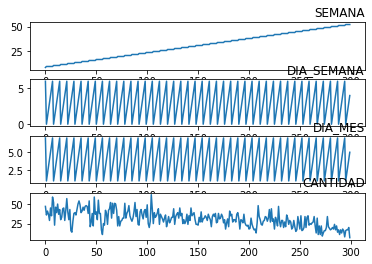

In [ ]:
# plot each column
values_plot = dataset.values

# columns to plot
groups = [3, 4, 5, 6]

i=1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values_plot[-300:, group])
	plt.title(dataset.columns[group], y=1, loc='right')
	i += 1
plt.show()

In [ ]:
 dataset.iloc[:, 3:7]

,SEMANA,DIA_SEMANA,DIA_MES,CANTIDAD
0,53,4,5,44.0
1,53,5,6,13.0
2,53,6,7,18.0
3,1,0,1,13.0
4,1,1,2,24.0
...,...,...,...,...
4378,52,0,1,16.0
4379,52,1,2,17.0
4380,52,2,3,17.0
4381,52,3,4,20.0


In [ ]:
#Select interest columns (DIA_SEMANA, DIA_MES, CANTIDAD)
values = dataset.iloc[:, 3:7].values
# ensure all data is float
values = values.astype('float32')
print(values.shape)

(4383, 4)


In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# frame as supervised learning
days_back = 5 #Days considered for the next prediction
reframed = series_to_supervised(scaled, days_back, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-2, -3, -4]], axis=1, inplace=True)
reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
5,1.0,0.666667,0.666667,0.473118,1.0,0.833333,0.833333,0.139785,1.0,1.000000,...,0.193548,0.0,0.000000,0.000000,0.139785,0.0,0.166667,0.166667,0.258065,0.204301
6,1.0,0.833333,0.833333,0.139785,1.0,1.000000,1.000000,0.193548,0.0,0.000000,...,0.139785,0.0,0.166667,0.166667,0.258065,0.0,0.333333,0.333333,0.204301,0.204301
7,1.0,1.000000,1.000000,0.193548,0.0,0.000000,0.000000,0.139785,0.0,0.166667,...,0.258065,0.0,0.333333,0.333333,0.204301,0.0,0.500000,0.500000,0.204301,0.204301
8,0.0,0.000000,0.000000,0.139785,0.0,0.166667,0.166667,0.258065,0.0,0.333333,...,0.204301,0.0,0.500000,0.500000,0.204301,0.0,0.666667,0.666667,0.204301,0.322581
9,0.0,0.166667,0.166667,0.258065,0.0,0.333333,0.333333,0.204301,0.0,0.500000,...,0.204301,0.0,0.666667,0.666667,0.204301,0.0,0.833333,0.833333,0.322581,0.107527


In [ ]:
# split into train and test sets
values = reframed.values
n_test_days = 60 #Lets separate 60 days for test
split_row = len(values)-n_test_days

train = values[:split_row, :]
print('Train dataset shape:', train.shape)
test = values[split_row:, :]
print('Test dataset shape:', test.shape)

n_features = 4 #features selected (DIA_SEMANA, DIA_MES, CANTIDAD)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print('Train X:', train_X.shape)
print('Test X:', test_X.shape)
# Reshape in case just one day back is used for prediction
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], days_back, n_features))
test_X = test_X.reshape((test_X.shape[0], days_back, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train dataset shape: (4318, 21)
Test dataset shape: (60, 21)
Train X: (4318, 20)
Test X: (60, 20)
(4318, 5, 4) (4318,) (60, 5, 4) (60,)


## Model

Epoch 1/80
48/48 - 6s - loss: 0.1030 - accuracy: 0.0012 - val_loss: 0.0839 - val_accuracy: 0.0000e+00
Epoch 2/80
48/48 - 0s - loss: 0.0777 - accuracy: 0.0012 - val_loss: 0.0673 - val_accuracy: 0.0000e+00
Epoch 3/80
48/48 - 0s - loss: 0.0737 - accuracy: 0.0014 - val_loss: 0.0652 - val_accuracy: 0.0000e+00
Epoch 4/80
48/48 - 0s - loss: 0.0734 - accuracy: 0.0016 - val_loss: 0.0593 - val_accuracy: 0.0000e+00
Epoch 5/80
48/48 - 0s - loss: 0.0729 - accuracy: 0.0016 - val_loss: 0.0632 - val_accuracy: 0.0000e+00
Epoch 6/80
48/48 - 0s - loss: 0.0719 - accuracy: 0.0014 - val_loss: 0.0656 - val_accuracy: 0.0000e+00
Epoch 7/80
48/48 - 0s - loss: 0.0727 - accuracy: 0.0016 - val_loss: 0.0601 - val_accuracy: 0.0000e+00
Epoch 8/80
48/48 - 0s - loss: 0.0722 - accuracy: 0.0016 - val_loss: 0.0618 - val_accuracy: 0.0000e+00
Epoch 9/80
48/48 - 0s - loss: 0.0720 - accuracy: 0.0016 - val_loss: 0.0620 - val_accuracy: 0.0000e+00
Epoch 10/80
48/48 - 0s - loss: 0.0722 - accuracy: 0.0016 - val_loss: 0.0629 - val_

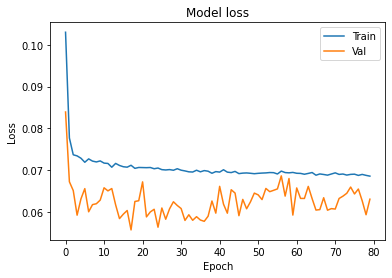

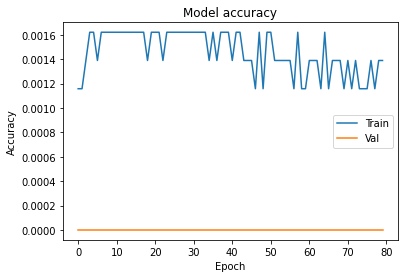

In [ ]:
#Build model
model = Sequential()

#First layer
model.add(LSTM(100, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
#Second layer
model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])


# fit model
history = model.fit(train_X, train_y, epochs=80, batch_size=90, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

### Results and evaluation

In [ ]:
print(test_X.shape)
# make a prediction
yhat = model.predict(test_X)
yhat.shape
X_to_invtransform = test_X.reshape((test_X.shape[0], days_back*n_features))
X_to_invtransform = X_to_invtransform[:, 17:20] #Se toman las que se usaron para escalar los datos


(60, 5, 4)


In [ ]:
X_to_invtransform.shape

(60, 3)

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((X_to_invtransform, yhat), axis=1) #Debe quedar en el mismo orden en que fue entrenado el scaler
inv_yhat.shape

(60, 4)

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]#Tomamos las columnas de interes
inv_yhat.shape

(60,)

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_y.shape

(60, 1)

In [ ]:
inv_y = concatenate((X_to_invtransform, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.402


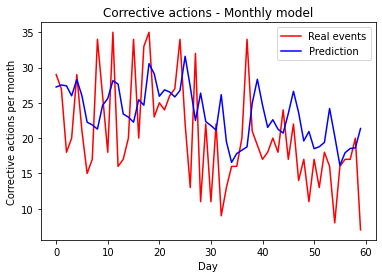

In [ ]:

# Visualizar los Resultados

plt.plot(inv_y, color = 'red', label = 'Real events')
plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

#plt.plot(np.concatenate([train_y[-1*days_back:], inv_y]), color = 'red', label = 'Real events')
#plt.plot(np.concatenate([np.zeros(len(train_y[-1*days_back:])), inv_yhat]), color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Monthly model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per month")
plt.legend()
plt.show()



In [ ]:
values_plot = dataset.iloc[:, 4:7].values
values_plot.shape

complete_y = values_plot[:, -1]
complete_y.shape

(4383,)

In [ ]:
temp_df_y = pd.DataFrame(complete_y)
temp_df_y["x1"] = temp_df_y.index
temp_df_y[0] = temp_df_y[0].round()
temp_df_y

,0,x1
0,44.0,0
1,13.0,1
2,18.0,2
3,13.0,3
4,24.0,4
...,...,...
4378,16.0,4378
4379,17.0,4379
4380,17.0,4380
4381,20.0,4381


In [ ]:
temp_df_pred = pd.DataFrame(inv_yhat)
temp_df_pred["x1"] = temp_df_pred.index + len(temp_df_y)-len(temp_df_pred)
temp_df_pred[0] = temp_df_pred[0].round()
temp_df_pred

,0,x1
0,27.0,4323
1,28.0,4324
2,27.0,4325
3,26.0,4326
4,28.0,4327
5,26.0,4328
6,22.0,4329
7,22.0,4330
8,21.0,4331
9,25.0,4332


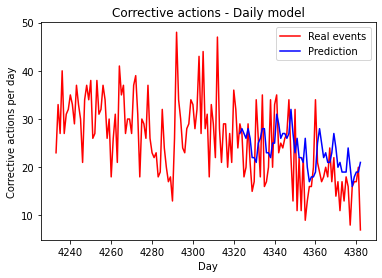

In [ ]:
# Visualizar los Resultados

plt.plot(temp_df_y['x1'][-150:], temp_df_y[0][-150:], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'], temp_df_pred[0] , color = 'blue', label = 'Prediction')

plt.title("Crimes - Daily model")
plt.xlabel("Day")
plt.ylabel("Crimes per day")
plt.legend()
plt.show()

In [ ]:
# Mean absolute error
mae = mean_absolute_error(inv_y,inv_yhat)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(inv_y,inv_yhat)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 5.883
El valor de error rmse es: 7.372
El valor de error R2 es: -0.085:


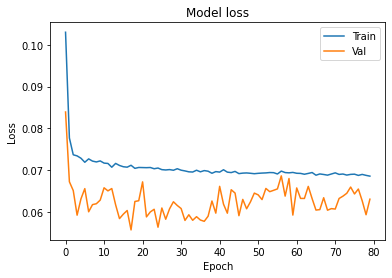

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

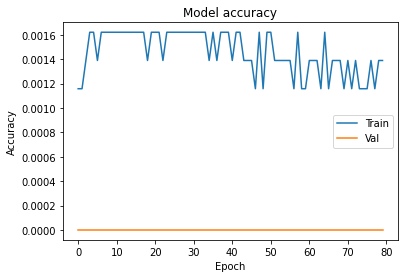

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

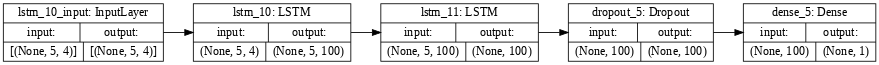

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=60,
    layer_range=None,
)

### Single prediction

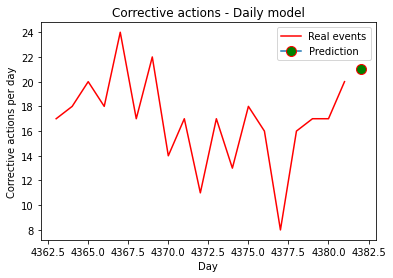

In [ ]:
import datetime
# Visualizar los Resultados

plt.plot(temp_df_y['x1'][-20:-1], temp_df_y[0][-20:-1], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'][-1:], temp_df_pred[0][-1:], marker="o", label = 'Prediction', markersize=10, markeredgecolor="red", markerfacecolor="green")

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

In [ ]:
import datetime
from datetime import timedelta
last_day = datetime.datetime.strptime(dataset.FECHA[-1:].values[0], '%Y-%m-%d')

temp_df_y['DATE'] = pd.date_range(start=last_day - timedelta(days=len(temp_df_y)-1), end=last_day)
temp_df_y

temp_df_pred['DATE'] = pd.date_range(start=last_day - timedelta(days=len(temp_df_pred)-1), end=last_day)
temp_df_pred

,0,x1,DATE
0,27.0,4323,2021-11-02
1,28.0,4324,2021-11-03
2,27.0,4325,2021-11-04
3,26.0,4326,2021-11-05
4,28.0,4327,2021-11-06
5,26.0,4328,2021-11-07
6,22.0,4329,2021-11-08
7,22.0,4330,2021-11-09
8,21.0,4331,2021-11-10
9,25.0,4332,2021-11-11


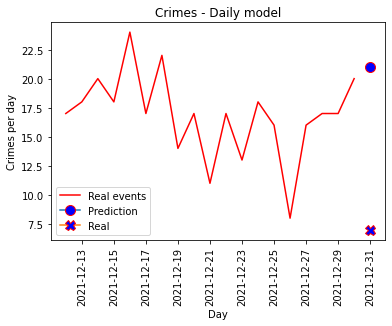

In [ ]:
plt.plot(temp_df_y['DATE'][-20:-1], temp_df_y[0][-20:-1], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['DATE'][-1:], temp_df_pred[0][-1:], marker="o", label = 'Prediction', markersize=10, markeredgecolor="red", markerfacecolor="blue")
plt.plot(temp_df_y['DATE'][-1:], temp_df_y[0][-1:], marker="X", label = 'Real', markersize=10, markeredgecolor="red", markerfacecolor="blue")

plt.title("Crimes - Daily model")
plt.xlabel("Day")
plt.ylabel("Crimes per day")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# MULTIVARIATE MODEL FOR WEEKLY CORRECTIVE ACTIONS

This model uses week number, year and previous months corrective actions to predict next month corrective actions.

Code in this section was adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

##Libraries

## Data processing

In [54]:
#Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/weekly_corrective_series.csv", index_col=0)
dataset.drop(columns=['x1'], inplace=True)
dataset

,ANO,SEMANA,CANTIDAD
0,2017,5,1.0
1,2017,6,265.0
2,2017,7,290.0
3,2017,8,233.0
4,2017,9,150.0
...,...,...,...
261,2022,5,681.0
262,2022,6,597.0
263,2022,7,737.0
264,2022,8,1093.0


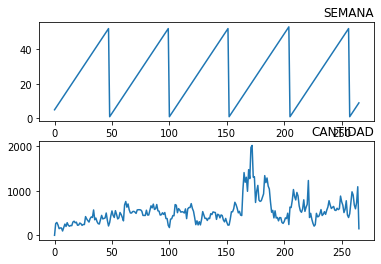

In [56]:
# plot each column
values_plot = dataset.values

# columns to plot
groups = [1, 2]

i=1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values_plot[-300:, group])
	plt.title(dataset.columns[group], y=1, loc='right')
	i += 1
plt.show()

In [57]:
dataset.iloc[:, 1:3]

,SEMANA,CANTIDAD
0,5,1.0
1,6,265.0
2,7,290.0
3,8,233.0
4,9,150.0
...,...,...
261,5,681.0
262,6,597.0
263,7,737.0
264,8,1093.0


In [58]:
#Select interest columns (AÑO, SEMANA, CANTIDAD)
values = dataset.iloc[:, 1:3].values
# ensure all data is float
values = values.astype('float32')
print(values.shape)

(266, 2)


In [59]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [60]:
# frame as supervised learning
weeks_back = 6 #Weeks considered for the next prediction
reframed = series_to_supervised(scaled, weeks_back, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-2,]], axis=1, inplace=True)
reframed.head()

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var2(t)
6,0.076923,0.000000,0.096154,0.130693,0.115385,0.143069,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.081188
7,0.096154,0.130693,0.115385,0.143069,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.048020
8,0.115385,0.143069,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.211538,0.048020,0.086634
9,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.211538,0.048020,0.230769,0.086634,0.124752
10,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.211538,0.048020,0.230769,0.086634,0.250000,0.124752,0.098515


In [61]:
# split into train and test sets
values = reframed.values
n_test_days = 20 #Lets separate 10 weeks for test
split_row = len(values)-n_test_days

train = values[:split_row, :]
print('Train dataset shape:', train.shape)
test = values[split_row:, :]
print('Test dataset shape:', test.shape)

n_features = 2 #features selected (DIA_SEMANA, DIA_MES, CANTIDAD)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1:]
print('Train X:', train_X.shape)
print('Test X:', test_X.shape)
# Reshape in case just one day back is used for prediction
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks_back, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks_back, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train dataset shape: (240, 13)
Test dataset shape: (20, 13)
Train X: (240, 12)
Test X: (20, 12)
(240, 6, 2) (240,) (20, 6, 2) (20, 1)


## Model

Epoch 1/100
8/8 - 3s - loss: 0.1937 - accuracy: 0.0000e+00 - val_loss: 0.1363 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 - 0s - loss: 0.1087 - accuracy: 0.0000e+00 - val_loss: 0.1012 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 - 0s - loss: 0.1155 - accuracy: 0.0000e+00 - val_loss: 0.0977 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 - 0s - loss: 0.1039 - accuracy: 0.0000e+00 - val_loss: 0.1098 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 - 0s - loss: 0.0963 - accuracy: 0.0000e+00 - val_loss: 0.1083 - val_accuracy: 0.0000e+00
Epoch 6/100
8/8 - 0s - loss: 0.0859 - accuracy: 0.0000e+00 - val_loss: 0.0946 - val_accuracy: 0.0000e+00
Epoch 7/100
8/8 - 0s - loss: 0.0830 - accuracy: 0.0000e+00 - val_loss: 0.0929 - val_accuracy: 0.0000e+00
Epoch 8/100
8/8 - 0s - loss: 0.0803 - accuracy: 0.0000e+00 - val_loss: 0.1012 - val_accuracy: 0.0000e+00
Epoch 9/100
8/8 - 0s - loss: 0.0754 - accuracy: 0.0000e+00 - val_loss: 0.0941 - val_accuracy: 0.0000e+00
Epoch 10/100
8/8 - 0s - loss: 0.0731 - accuracy: 0.0042

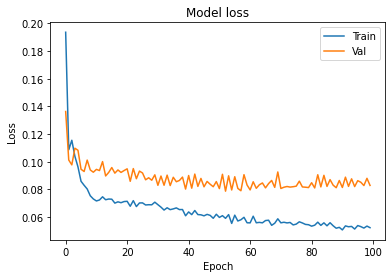

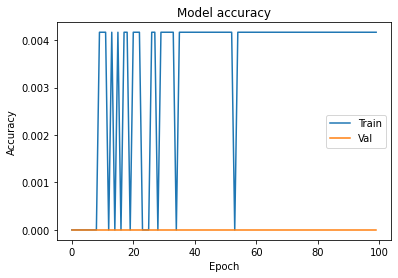

In [62]:
#Build model
model = Sequential()

#First layer
model.add(LSTM(30, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))

#Second layer
model.add(LSTM(units = 30))
model.add(Dropout(0.1))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# fit model
history_2 = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

### Results and evaluation

In [63]:
print(test_X)
print(test_X.shape)
print("PREDICCION")
# make a prediction

yhat = model.predict(test_X)
yhat.shape
X_to_invtransform = test_X.reshape((test_X.shape[0], weeks_back*n_features))
X_to_invtransform = X_to_invtransform[:, -2:-1] #Se toman las que se usaron para escalar los datos
print(X_to_invtransform.shape)

[[[0.6730769  0.33663368]
  [0.6923077  0.29851487]
  [0.7115385  0.31138614]
  [0.7307692  0.32128716]
  [0.75       0.28019804]
  [0.7692308  0.27623764]]

 [[0.6923077  0.29851487]
  [0.7115385  0.31138614]
  [0.7307692  0.32128716]
  [0.75       0.28019804]
  [0.7692308  0.27623764]
  [0.78846157 0.30148515]]

 [[0.7115385  0.31138614]
  [0.7307692  0.32128716]
  [0.75       0.28019804]
  [0.7692308  0.27623764]
  [0.78846157 0.30148515]
  [0.80769235 0.28564358]]

 [[0.7307692  0.32128716]
  [0.75       0.28019804]
  [0.7692308  0.27623764]
  [0.78846157 0.30148515]
  [0.80769235 0.28564358]
  [0.8269231  0.2960396 ]]

 [[0.75       0.28019804]
  [0.7692308  0.27623764]
  [0.78846157 0.30148515]
  [0.80769235 0.28564358]
  [0.8269231  0.2960396 ]
  [0.84615386 0.43663368]]

 [[0.7692308  0.27623764]
  [0.78846157 0.30148515]
  [0.80769235 0.28564358]
  [0.8269231  0.2960396 ]
  [0.84615386 0.43663368]
  [0.86538464 0.3727723 ]]

 [[0.78846157 0.30148515]
  [0.80769235 0.28564358]


In [64]:
X_to_invtransform.shape

(20, 1)

In [65]:
# invert scaling for forecast
inv_yhat = concatenate((X_to_invtransform, yhat), axis=1) #Debe quedar en el mismo orden en que fue entrenado el scaler
inv_yhat.shape

(20, 2)

In [66]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]#Tomamos las columnas de interes
inv_yhat.shape

(20,)

In [67]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_y.shape

(20, 1)

In [68]:
inv_y = concatenate((X_to_invtransform, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 231.356


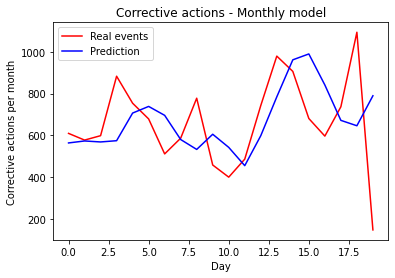

In [69]:

# Visualizar los Resultados

plt.plot(inv_y, color = 'red', label = 'Real events')
plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

#plt.plot(np.concatenate([train_y[-1*days_back:], inv_y]), color = 'red', label = 'Real events')
#plt.plot(np.concatenate([np.zeros(len(train_y[-1*days_back:])), inv_yhat]), color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Monthly model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per month")
plt.legend()
plt.show()



In [70]:
values_plot = values = dataset.iloc[:, 1:3].values
values_plot.shape

complete_y = values_plot[:, -1]
complete_y.shape

(266,)

In [71]:
temp_df_y = pd.DataFrame(complete_y)
temp_df_y["x1"] = temp_df_y.index
temp_df_y[0] = temp_df_y[0].round()
temp_df_y

,0,x1
0,1.0,0
1,265.0,1
2,290.0,2
3,233.0,3
4,150.0,4
...,...,...
261,681.0,261
262,597.0,262
263,737.0,263
264,1093.0,264


In [72]:
temp_df_pred = pd.DataFrame(inv_yhat)
temp_df_pred["x1"] = temp_df_pred.index + len(temp_df_y)-len(temp_df_pred)
temp_df_pred[0] = temp_df_pred[0].round()
temp_df_pred

,0,x1
0,564.0,246
1,574.0,247
2,569.0,248
3,575.0,249
4,707.0,250
5,739.0,251
6,696.0,252
7,581.0,253
8,533.0,254
9,606.0,255


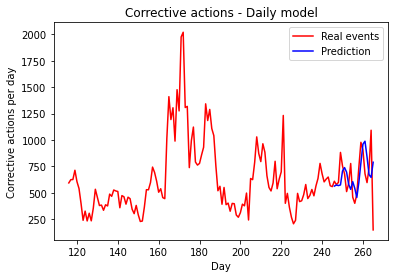

In [73]:
# Visualizar los Resultados

#plt.plot(inv_y, color = 'red', label = 'Real events')
#plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

plt.plot(temp_df_y['x1'][-150:], temp_df_y[0][-150:], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'], temp_df_pred[0] , color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

In [74]:
# Mean absolute error
mae = mean_absolute_error(inv_y,inv_yhat)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(inv_y,inv_yhat)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 167.450
El valor de error rmse es: 231.458
El valor de error R2 es: -0.220:


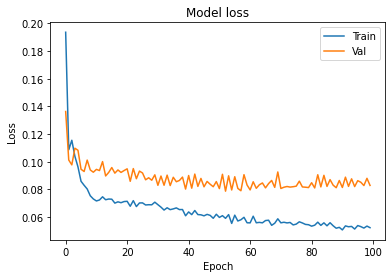

In [76]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

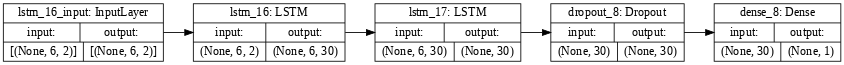

In [77]:
tf.keras.utils.plot_model(
    model,
    #to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=60,
    layer_range=None,
    #show_layer_activations = True
)

### Single prediction

In [ ]:
import datetime
# Visualizar los Resultados

#plt.plot(inv_y, color = 'red', label = 'Real events')
#plt.plot(inv_yhat, color = 'blue', label = 'Prediction')

plt.plot(temp_df_y['x1'][-20:-1], temp_df_y[0][-20:-1], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'][-1:], temp_df_pred[0][-1:], marker="o", label = 'Prediction', markersize=10, markeredgecolor="red", markerfacecolor="blue")

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

# SINGLE NEIGHBORHOOD MULTIVARIATE MODEL (MONTH)

## Data processing

In [10]:
#Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/monthly_neighborhood_series.csv", index_col=0)
dataset

,ANO,MES,LA AURORA,EL PRADO,CABECERA DEL LLANO,SOTOMAYOR,ANTONIA SANTOS CENTRO,LA CONCORDIA,COLORADOS,EL PABLÓN,...,LAURELES I,HACIENDA SAN JUAN,SAN EXPEDITO,DELICIAS BAJAS,VILLA SARA,VILLA FLOR,ALTOS DEL CACIQUE,BARRIO NUEVO,LOS ANAYA,CHITOTA
0,2017,2,11.0,1.0,22.0,21.0,30.0,36.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,3,6.0,3.0,32.0,6.0,103.0,21.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,4,2.0,12.0,51.0,12.0,54.0,22.0,16.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,5,21.0,4.0,49.0,47.0,154.0,26.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,6,28.0,17.0,74.0,37.0,188.0,13.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2021,10,31.0,3.0,96.0,30.0,51.0,47.0,55.0,9.0,...,0.0,0.0,0.0,3.0,9.0,0.0,0.0,3.0,0.0,0.0
57,2021,11,28.0,12.0,130.0,37.0,134.0,101.0,120.0,50.0,...,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
58,2021,12,20.0,3.0,123.0,37.0,44.0,65.0,80.0,12.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
59,2022,1,57.0,13.0,144.0,67.0,128.0,88.0,117.0,15.0,...,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
multivariate_features = [0, 1]
neighborhood_col = [57]
multivariate_features + neighborhood_col

[0, 1, 57]

In [ ]:
data = dataset.iloc[:, multivariate_features + neighborhood_col]
data

,ANO,MES,COLSEGUROS NORTE
0,2017,2,5.0
1,2017,3,0.0
2,2017,4,0.0
3,2017,5,2.0
4,2017,6,0.0
...,...,...,...
56,2021,10,15.0
57,2021,11,0.0
58,2021,12,0.0
59,2022,1,6.0


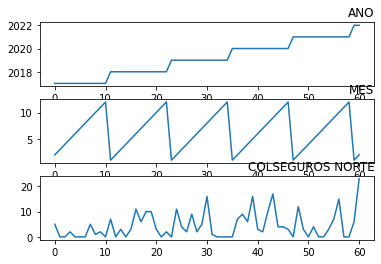

In [ ]:
# plot each column
values_plot = data.values

# columns to plot
groups = [i for i,j in enumerate(data.columns)]

i=1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values_plot[-300:, group])
	plt.title(data.columns[group], y=1, loc='right')
	i += 1
plt.show()

In [ ]:
values = data.values
# ensure all data is float
values = values.astype('float32')
print(values.shape)

(61, 3)


In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# frame as supervised learning
weeks_back = 3 #Weeks considered for the next prediction
reframed = series_to_supervised(scaled, weeks_back, 1)
columns2drop = [-1*(i+2) for i in range(len(multivariate_features))]
# drop columns we don't want to predict
reframed.drop(reframed.columns[columns2drop], axis=1, inplace=True)
reframed.head()

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t)
6,0.076923,0.000000,0.096154,0.130693,0.115385,0.143069,0.134615,0.114851,0.153846,0.073762,0.173077,0.081188
7,0.096154,0.130693,0.115385,0.143069,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.192308,0.048020
8,0.115385,0.143069,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.211538,0.086634
9,0.134615,0.114851,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.211538,0.048020,0.230769,0.124752
10,0.153846,0.073762,0.173077,0.082178,0.192308,0.081188,0.211538,0.048020,0.230769,0.086634,0.250000,0.098515


In [ ]:
# split into train and test sets
values = reframed.values
n_test_days = 20 #Lets separate 10 weeks for test
split_row = len(values)-n_test_days

train = values[:split_row, :]
print('Train dataset shape:', train.shape)
test = values[split_row:, :]
print('Test dataset shape:', test.shape)

n_features = len(multivariate_features + neighborhood_col) #features selected (DIA_SEMANA, DIA_MES, CANTIDAD)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1:]
print('Train X:', train_X.shape)
print('Test X:', test_X.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks_back, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks_back, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train dataset shape: (38, 12)
Test dataset shape: (20, 12)
Train X: (38, 11)
Test X: (20, 11)


ValueError: ignored

## Model

Epoch 1/200
2/2 - 9s - loss: 0.1760 - accuracy: 0.3158 - val_loss: 0.2282 - val_accuracy: 0.3000
Epoch 2/200
2/2 - 0s - loss: 0.1661 - accuracy: 0.3158 - val_loss: 0.2162 - val_accuracy: 0.3000
Epoch 3/200
2/2 - 0s - loss: 0.1608 - accuracy: 0.3158 - val_loss: 0.2053 - val_accuracy: 0.3000
Epoch 4/200
2/2 - 0s - loss: 0.1511 - accuracy: 0.3158 - val_loss: 0.1976 - val_accuracy: 0.3000
Epoch 5/200
2/2 - 0s - loss: 0.1503 - accuracy: 0.3158 - val_loss: 0.1974 - val_accuracy: 0.3000
Epoch 6/200
2/2 - 0s - loss: 0.1470 - accuracy: 0.3158 - val_loss: 0.1992 - val_accuracy: 0.3000
Epoch 7/200
2/2 - 0s - loss: 0.1500 - accuracy: 0.3158 - val_loss: 0.2026 - val_accuracy: 0.3000
Epoch 8/200
2/2 - 0s - loss: 0.1467 - accuracy: 0.3158 - val_loss: 0.2047 - val_accuracy: 0.3000
Epoch 9/200
2/2 - 0s - loss: 0.1441 - accuracy: 0.3158 - val_loss: 0.2057 - val_accuracy: 0.3000
Epoch 10/200
2/2 - 0s - loss: 0.1442 - accuracy: 0.3158 - val_loss: 0.2073 - val_accuracy: 0.3000
Epoch 11/200
2/2 - 0s - loss:

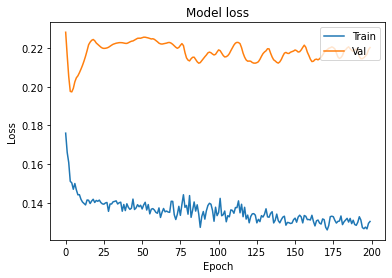

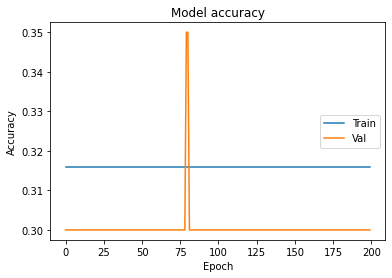

In [ ]:
#Build model
model = Sequential()

#First layer
model.add(LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))

#Second layer
model.add(LSTM(units = 50))
model.add(Dropout(0.1))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# fit model
history_2 = model.fit(train_X, train_y, epochs=200, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='center right')
plt.show()

### Results and evaluation

In [ ]:
print(test_X.shape)
# make a prediction
yhat = model.predict(test_X)
yhat.shape

X_to_invtransform = test_X.reshape((test_X.shape[0], weeks_back*n_features))
X_to_invtransform = X_to_invtransform[:, -1*(len(multivariate_features)+2):-2] #Se toman las que se usaron para escalar los datos
X_to_invtransform.shape

(20, 3, 3)


(20, 2)

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((X_to_invtransform, yhat), axis=1) #Debe quedar en el mismo orden en que fue entrenado el scaler
inv_yhat.shape

(20, 3)

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]#Tomamos las columnas de interes
inv_yhat.shape

(20,)

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_y.shape

(20, 1)

In [ ]:
inv_y = concatenate((X_to_invtransform, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.489


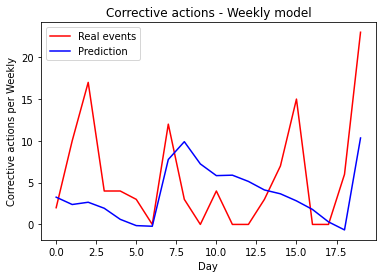

In [ ]:

# Visualizar los Resultados

plt.plot(inv_y, color = 'red', label = 'Real events')
plt.plot(inv_yhat, color = 'blue', label = 'Prediction')


plt.title("Corrective actions - Weekly model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per Weekly")
plt.legend()
plt.show()



In [ ]:
values_plot = data.iloc[:, -1:].values
values_plot.shape

complete_y = values_plot[:, -1]
complete_y.shape

(61,)

In [ ]:
temp_df_y = pd.DataFrame(complete_y)
temp_df_y["x1"] = temp_df_y.index
temp_df_y[0] = temp_df_y[0].round()
temp_df_y

,0,x1
0,5.0,0
1,0.0,1
2,0.0,2
3,2.0,3
4,0.0,4
...,...,...
56,15.0,56
57,0.0,57
58,0.0,58
59,6.0,59


In [ ]:
temp_df_pred = pd.DataFrame(inv_yhat)
temp_df_pred["x1"] = temp_df_pred.index + len(temp_df_y)-len(temp_df_pred)
temp_df_pred[0] = temp_df_pred[0].round()
temp_df_pred

,0,x1
0,3.0,41
1,2.0,42
2,3.0,43
3,2.0,44
4,1.0,45
5,-0.0,46
6,-0.0,47
7,8.0,48
8,10.0,49
9,7.0,50


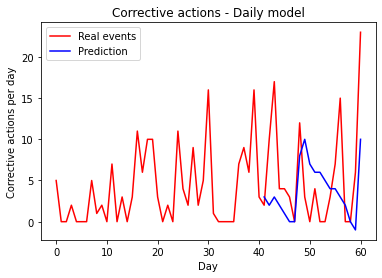

In [ ]:
# Visualizar los Resultados

plt.plot(temp_df_y['x1'][:], temp_df_y[0][:], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'], temp_df_pred[0] , color = 'blue', label = 'Prediction')

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

In [ ]:
# Mean absolute error
mae = mean_absolute_error(inv_y,inv_yhat)
print("El valor absoluto del error es: %.3f"%mae)

#RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print("El valor de error rmse es: %.3f"%rmse)

#R¨2
r2 = r2_score(inv_y,inv_yhat)
print("El valor de error R2 es: %.3f:" % r2)

El valor absoluto del error es: 5.000
El valor de error rmse es: 6.473
El valor de error R2 es: -0.031:


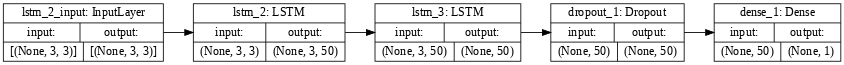

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=60,
    layer_range=None,
)

### Single prediction

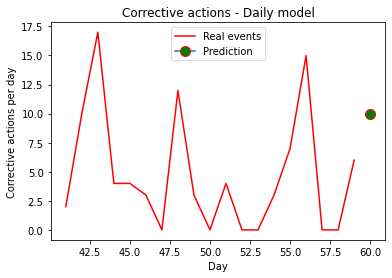

In [ ]:
import datetime
# Visualizar los Resultados

plt.plot(temp_df_y['x1'][-20:-1], temp_df_y[0][-20:-1], color = 'red', label = 'Real events')
plt.plot(temp_df_pred['x1'][-1:], temp_df_pred[0][-1:], marker="o", label = 'Prediction', markersize=10, markeredgecolor="red", markerfacecolor="green")

plt.title("Corrective actions - Daily model")
plt.xlabel("Day")
plt.ylabel("Corrective actions per day")
plt.legend()
plt.show()

## ALL NEIGHBORHOODS FORECAST FUNCTION

In [9]:
def get_neighborhood_predictions(dataframe, multivariate_features, neighborhood_cols, time_back=5, train=True, epochs=10):

  next_week = dataframe.iloc[-1, 1]+1

  if next_week < 12:
    result = [dataframe.iloc[-1, 0], next_week]
  else:
    result = [dataframe.iloc[-1, 0]+1, next_week]

  print(result)
  for n, k in enumerate(neighborhood_cols):
    neighborhood_col = list()
    neighborhood_col.append(k)
    multivariate_features + neighborhood_col
    print("Training model",  n, "of" , len(neighborhood_cols)-1)
    data = dataset.iloc[:, multivariate_features + neighborhood_col]
    values = data.values
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    #Save scaler for future predictions
    joblib.dump(scaler, dataframe.columns[0 + len(multivariate_features)] + '.gz')

    reframed = series_to_supervised(scaled, time_back, 1)
    columns2drop = [-1*(i+2) for i in range(len(multivariate_features))]
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[columns2drop], axis=1, inplace=True)

    # splittim into train and test sets
    values = reframed.values
    n_test_days = 10 #Lets separate 10 weeks for test
    split_row = len(values)-n_test_days

    train = values[:split_row, :]

    test = values[split_row:, :]

    n_features = len(multivariate_features + neighborhood_col)
    
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1:]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_back, n_features))
    test_X = test_X.reshape((test_X.shape[0], time_back, n_features))

    #Build model
    model = Sequential()

    #First layer
    model.add(LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))

    #Second layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.1))

    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

    # fit model
    history_2 = model.fit(train_X, train_y, epochs=epochs, batch_size=30, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    #Save scaler for future predictions
    model.save(dataframe.columns[0 + len(multivariate_features)] +'.h5')


    # make a prediction
    last_registers = series_to_supervised(scaled[time_back*-2:, :], time_back, 1)
    last_registers = last_registers[-1:]
    last_registers.drop(last_registers.columns[[i for i in range(len(multivariate_features)+1)]], axis=1, inplace=True)
    last_registers = last_registers.values
    last_registers = last_registers.reshape((1, time_back, n_features))

    yhat = model.predict(last_registers)

    X_to_invtransform = last_registers[-1]
    X_to_invtransform = X_to_invtransform[-1:, [-i-1 for i in range(len(multivariate_features))]]

    # invert scaling for forecast
    inv_yhat = concatenate((X_to_invtransform, yhat), axis=1) #Debe quedar en el mismo orden en que fue entrenado el scaler

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]#Tomamos las columnas de interes

    #Rectificamos si es menor a cero, de lo contrario se redondea el resultado
    result.append(0 if inv_yhat < 0 else round(inv_yhat[0]))

    print(result[-1])
  return result

[2022, 3]
Training model 0 of 142
28
Training model 1 of 142
7
Training model 2 of 142
94
Training model 3 of 142
66
Training model 4 of 142
114
Training model 5 of 142
116
Training model 6 of 142
41
Training model 7 of 142
0
Training model 8 of 142
0
Training model 9 of 142
53
Training model 10 of 142
2
Training model 11 of 142
109
Training model 12 of 142
200
Training model 13 of 142
0
Training model 14 of 142
2
Training model 15 of 142
17
Training model 16 of 142
60
Training model 17 of 142
490
Training model 18 of 142
4
Training model 19 of 142
12
Training model 20 of 142
10
Training model 21 of 142
0
Training model 22 of 142
18
Training model 23 of 142
22
Training model 24 of 142
0
Training model 25 of 142
2
Training model 26 of 142
69
Training model 27 of 142
24
Training model 28 of 142
35
Training model 29 of 142
52
Training model 30 of 142
8
Training model 31 of 142
7
Training model 32 of 142
6
Training model 33 of 142
7
Training model 34 of 142
0
Training model 35 of 142
42
Tr

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0, flags=flags)


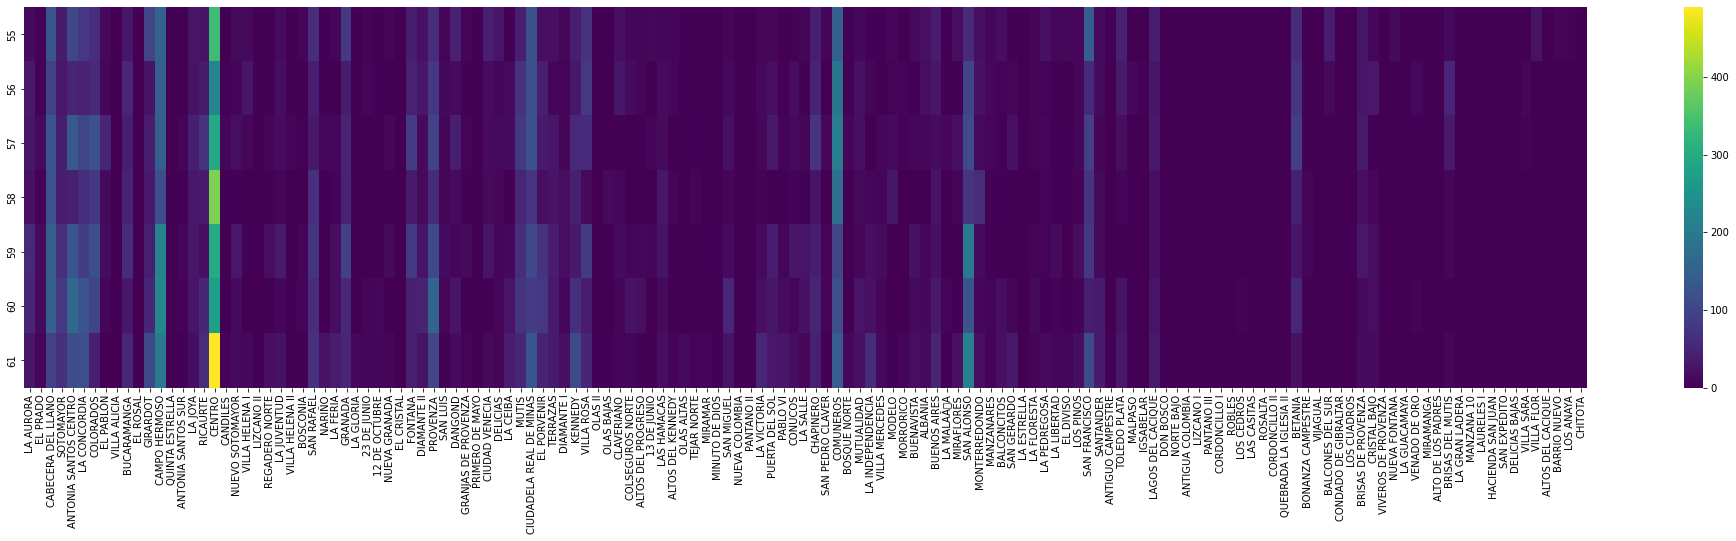

In [11]:
#Load dataset of corrective actions
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/monthly_corrective_neighborhood_series.csv", index_col=0)
dataset

multivariate_cols = [0,1]
neighborhood_cols = [i for i in range(dataset.shape[1]) if i not in multivariate_cols]

result = get_neighborhood_predictions(dataset, multivariate_cols, neighborhood_cols, time_back=5, epochs=100)
dataset.loc[len(dataset.index)] = result
dataset.to_csv('/content/drive/MyDrive/Team 111 DS4A - Project/Time series/corrective_neighborhood_with_prediction.csv')  

plt.figure(figsize = (35, 7))
sns.heatmap(dataset.iloc[-7:, ~dataset.columns.isin(['ANO', 'MES'])],
            cmap="viridis",
            xticklabels=True,
            yticklabels=True,
            )

[2022, 13]
Training model 0 of 483
6
Training model 1 of 483
12
Training model 2 of 483
13
Training model 3 of 483
16
Training model 4 of 483
2
Training model 5 of 483
2
Training model 6 of 483
22
Training model 7 of 483
19
Training model 8 of 483
0
Training model 9 of 483
0
Training model 10 of 483
4
Training model 11 of 483
2
Training model 12 of 483
0
Training model 13 of 483
0
Training model 14 of 483
0
Training model 15 of 483
83
Training model 16 of 483
0
Training model 17 of 483
5
Training model 18 of 483
3
Training model 19 of 483
0
Training model 20 of 483
0
Training model 21 of 483
39
Training model 22 of 483
2
Training model 23 of 483
5
Training model 24 of 483
13
Training model 25 of 483
10
Training model 26 of 483
45
Training model 27 of 483
0
Training model 28 of 483
5
Training model 29 of 483
3
Training model 30 of 483
9
Training model 31 of 483
0
Training model 32 of 483
54
Training model 33 of 483
0
Training model 34 of 483
4
Training model 35 of 483
3
Training model 3

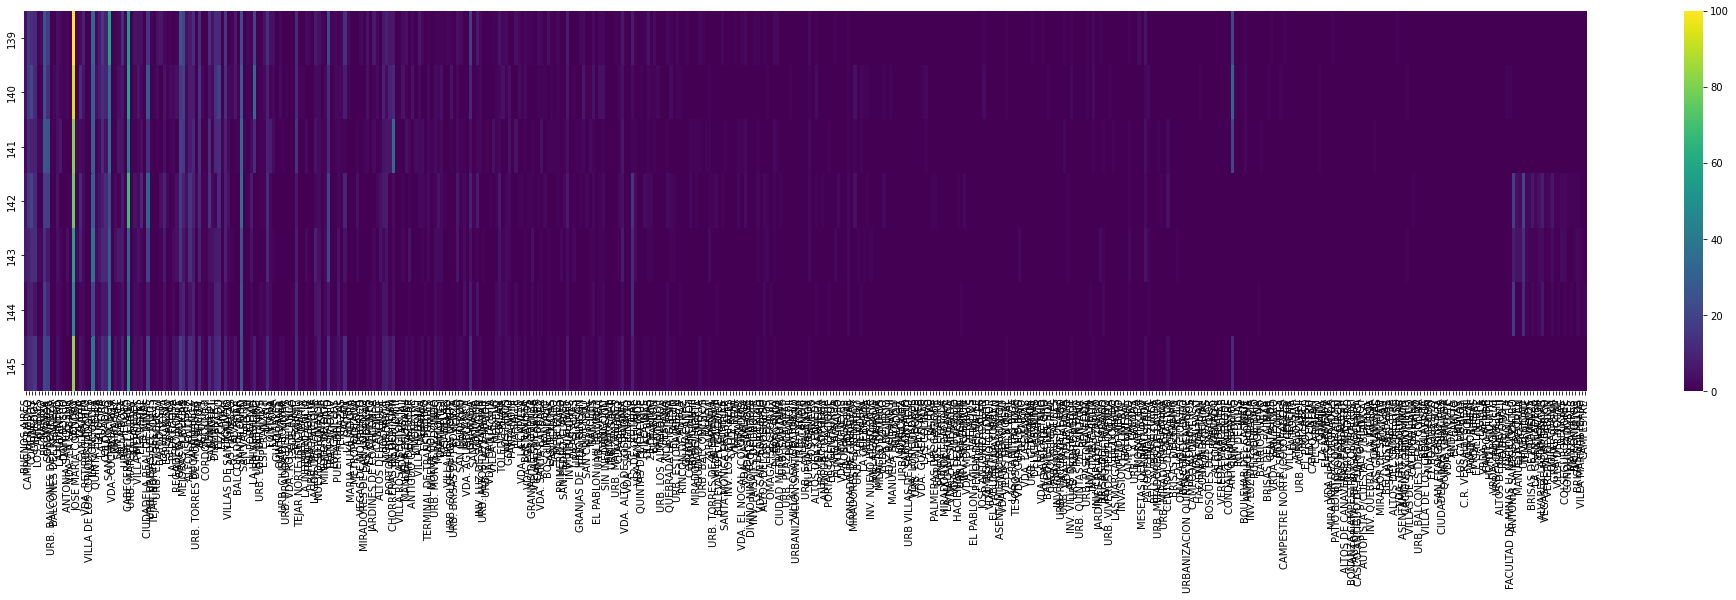

In [16]:
#Load dataset of crimes and generate prediction model for each neighborhood
dataset = pd.read_csv("/content/drive/MyDrive/Team 111 DS4A - Project/Time series/monthly_crimes_neighborhood_series.csv", index_col=0)
dataset

multivariate_cols = [0,1]
neighborhood_cols = [i for i in range(dataset.shape[1]) if i not in multivariate_cols]

result = get_neighborhood_predictions(dataset, multivariate_cols, neighborhood_cols, time_back=5, epochs=100)
dataset.loc[len(dataset.index)] = result
dataset.to_csv('/content/drive/MyDrive/Team 111 DS4A - Project/Time series/crimes_neighborhood_with_prediction.csv')  

plt.figure(figsize = (35, 7))
sns.heatmap(dataset.iloc[-7:, ~dataset.columns.isin(['ANO', 'MES'])],
            cmap="viridis",
            xticklabels=True,
            yticklabels=True,
            )